In [1]:
import os
from matplotlib.colors import LinearSegmentedColormap
import pickle
import matplotlib.pyplot as plt
import uuid


new_dir = '/home/ma/ma_ma/ma_lineuman/Interpretable-Deep-Fake-Detection/results'
if os.path.exists(new_dir):
    os.chdir(new_dir)
    print("Changed working directory to:", os.getcwd())
else:
    print("Directory does not exist")

Changed working directory to: /pfs/data6/home/ma/ma_ma/ma_lineuman/Interpretable-Deep-Fake-Detection/results


In [43]:
def visualize_and_save(img_np, heatmap, true_fake_pos, weighted_guessed_fake_position, weighted_localization_score, unweighted_localization_score, unweighted_guessed_fake_position, grid_split, model_prediction, save_folder="results", file_prefix="visualization"):
    """
    Visualisiert das Originalbild und die Heatmap nebeneinander und speichert die Abbildung unter einem eindeutigen Dateinamen.
    """
    print(f"[DEBUG] Visualizing heatmap with shape: {heatmap.shape}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # --- Linke Seite: Originalbild ---
    ax1.imshow(img_np)
    ax1.set_title("Original Image")
    ax1.axis("off")

    colors = ["white", "red"]
    custom_cmap = LinearSegmentedColormap.from_list("white_to_red", colors)
    
    # --- Rechte Seite: Heatmap ---
    ax2.imshow(heatmap, cmap=custom_cmap)
    ax2.set_title("Heatmap")
    ax2.axis("off")

    # Überschrift mit Anmerkungen
    #fig.suptitle(
    #    f"True Fake Pos: {true_fake_pos}, weighted Guess: {weighted_guessed_fake_position}, unweighted Guess: {unweighted_guessed_fake_position}\n"
    #    f"Intensity-Weighted Localization Score: {weighted_localization_score:.4f}, Unweighted Localization Score: {unweighted_localization_score:.4f}, Modelprediction: {model_prediction}"
    #)

    plt.tight_layout()

    # Sicherstellen, dass der Speicherordner existiert.
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    # Eindeutigen Dateinamen generieren: Prefix, echte/erratene Position und ein zufälliger UUID-Teil.
    unique_id = uuid.uuid4().hex[:8]
    filename = f"{file_prefix}_{true_fake_pos}_{unweighted_guessed_fake_position}_{unique_id}.png"
    filepath = os.path.join(save_folder, filename)

    # Abbildung speichern.
    plt.savefig(filepath)
    print(f"Saved visualization to {filepath}")

    plt.show()

########################################################################################################################################################################

Visulize top 10 grid per model

In [ ]:
results_file = os.path.join("/pfs/work9/workspace/scratch/ma_tischuet-team_project_explainable_deepfakes/resultsGPG","resnet34_bcos_v2_test_bcos_res_2_config","3x3","results_by_threshold.pkl")
print("Results file path:", os.path.abspath(results_file))

with open(results_file, "rb") as f:
    results = pickle.load(f)

# 2) pick out only the threshold==0 entries
#    (we saved threshold=None as 0 in the dict keys)
threshold0 = results.get(0, [])

# 3) sort by unweighted localization score and take top 10
top10 = sorted(
    threshold0,
    key=lambda r: r.get("weighted_localization_score", 0),
    reverse=True
)[:10]

grid_split = 3  # your grid size

# 4) visualize
for rank, best in enumerate(top10, 1):
    img_np   = best["original_image"]
    heatmap  = best["heatmap"]
    true_fp  = best["true_fake_position"]
    wg_fp    = best["weighted_guessed_fake_position"]
    wg_score = best["weighted_localization_score"]
    uw_score = best["unweighted_localization_score"]
    uw_fp    = best["unweighted_guess_fake_position"]
    pred     = best["model_prediction"]
    # threshold is always 0 here

    print(f"{rank}. wg_score={wg_score:.3f}, true={true_fp}, wg_guess={wg_fp}")

    visualize_and_save(
        img_np,
        heatmap,
        true_fp,
        wg_fp,
        wg_score,
        uw_score,
        uw_fp,
        grid_split,
        pred,
        save_folder="results/top10_thresh0",
        file_prefix=f"#{rank}"
    )

###################################################################################################################################################################################################

Visulize all Grids !!!!!Warning!!!!!!

In [ ]:
with open(results_file, "rb") as f:
    results = pickle.load(f)

for threshold, result_list in results.items():
    for result in result_list:
        path = result.get("path")
        img_np = result.get("original_image")
        heatmap = result.get("heatmap")
        true_fake_pos = result.get("true_fake_position")
        weighted_guessed_fake_position = result.get("weighted_guessed_fake_position")
        unweighted_guess_fake_position = result.get("unweighted_guess_fake_position")
        model_prediction = result.get("model_prediction")
        weighted_localization_score = result.get("weighted_localization_score", 0.0)
        unweighted_localization_score = result.get("unweighted_localization_score", 0.0)

        grid_split = 3  # oder 4 oder was auch immer du verwendet hast
        print(f"[DEBUG] img_np shape after transpose: {img_np.shape}, dtype: {img_np.dtype}, max: {img_np.max()}")


        
        print(f"Threshold {threshold} | Weighted localization score: {weighted_localization_score:.2f} | weighted Guessed: {weighted_guessed_fake_position} | True: {true_fake_pos}")
        visualize_and_save(img_np, heatmap, true_fake_pos, weighted_guessed_fake_position, weighted_localization_score, unweighted_localization_score, unweighted_guess_fake_position, grid_split, model_prediction, save_folder="results", file_prefix="visualization")


################################################################################################################################################################################################################################################################################################################################################################

Visulization of mean accuracies

In [29]:
import os
import pickle
import numpy as np

# ─────────── CONFIG ───────────
models = [
    #"resnet34_bcos_v2_test_bcos_res_2_5_config",
    #"resnet34_bcos_v2_test_bcos_res_2_config",
    "resnet34_bcos_v2_test_bcos_res_1_75_config",
    #"resnet34_test_res_lime_config",
    #"resnet34_test_res_xgrad_config",
    #"resnet34_test_res_layergrad_config",
    #"resnet34_test_res_grad++_config",
    #"resnet34_test_res_gradcam_config",

    #"xception_bcos_detector_test_bcos_xception_2_5_config",
    #"xception_test_xception_lime_config",
    #"xception_test_xception_xgrad_config",
    #"xception_test_xception_layergrad_config",
    #"xception_test_xception_grad++_config",
    #"xception_test_xception_gradcam_config",
    
    #"resnet34_bcos_v2_test_MPG_bcos_1_75",
    #"resnet34_bcos_v2_test_MPG_gradcam",
    #"resnet34_bcos_v2_test_MPG_grad++",
    #"resnet34_bcos_v2_test_MPG_xgrad",
    #"resnet34_bcos_v2_test_MPG_layergrad",
    #"resnet34_bcos_v2_test_MPG_bcos_1_75",
    #"resnet34_bcos_v2_test_MPG_bcos_2",
    #"resnet34_bcos_v2_test_MPG_bcos_2_5",
    #"resnet34_test_MPG_lime",
    #"resnet34_test_MPG_gradcam",
    #"resnet34_test_MPG_xgrad",
    #"resnet34_test_MPG_grad++",
    #"resnet34_test_MPG_layergrad",
    
    #"vit_bcos_test_MPG_bcos_1_25",
    #"vit_bcos_test_MPG_bcos_1_75",
    #"vit_bcos_test_MPG_bcos_2",
    #"vit_bcos_test_MPG_bcos_2_5",
    #"vit_test_MPG_lime",
    #"vit_test_MPG_gradcam",
    #"vit_test_MPG_xgrad",
    #"vit_test_MPG_grad++",
    #"vit_test_MPG_layergrad",
    
    #"xception_test_MPG_lime",
    #"xception_test_MPG_gradcam",
    #"xception_test_MPG_xgrad",
    #"xception_test_MPG_grad++",
    #"xception_test_MPG_layergrad",
    #"xception_bcos_detector_test_MPG_bcos_2_5"
    # ggf. weitere Modelle hier
]
results_base = "/pfs/work9/workspace/scratch/ma_tischuet-team_project_explainable_deepfakes/resultsGPG"
grid_subpath  = "3x3"
threshold_key = 0  # unser „no threshold“, wird im Dict als 0 gespeichert
# ───────────────────────────────

print("| Model                                           | Weighted avg | Unweighted avg |")
print("|:------------------------------------------------|------------:|---------------:|")

for m in models:
    pkl = os.path.join(results_base, m, grid_subpath, "results_by_threshold.pkl")
    with open(pkl, "rb") as f:
        res = pickle.load(f)
    entries = res.get(threshold_key, [])
    if not entries:
        print(f"| {m:48} |      n/a    |       n/a     |")
        continue

    w_scores = [e["weighted_localization_score"]   for e in entries]
    u_scores = [e["unweighted_localization_score"] for e in entries]
    w_mean = np.mean(w_scores)
    u_mean = np.mean(u_scores)

    print(f"| {m:48} | {w_mean:12.4f} | {u_mean:14.4f} |")
    print 

| Model                                           | Weighted avg | Unweighted avg |
|:------------------------------------------------|------------:|---------------:|
| resnet34_bcos_v2_test_bcos_res_1_75_config       |       0.2624 |         0.1111 |


Graph Weighted localization score x treshhold (each on own data)

Saved visualization to results/MPG_mixed_threshhold_per_LScore_6d12d32e.png


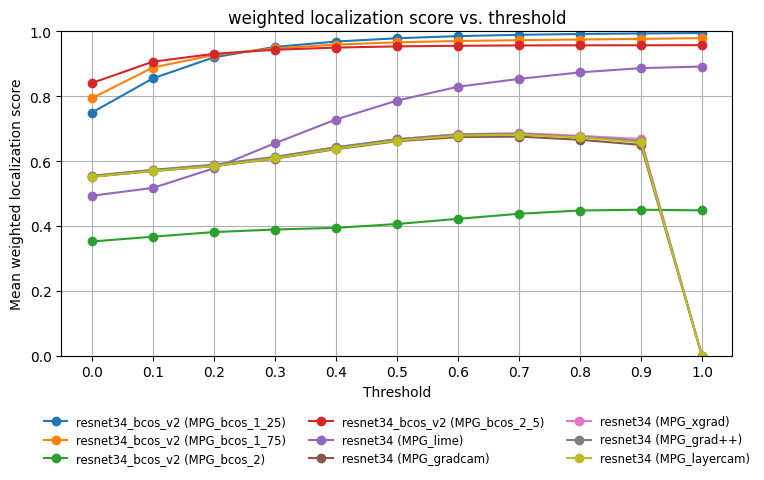

In [25]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

# ─────────── CONFIG ───────────
models = [
    #"resnet34_bcos_v2_test_bcos_res_1_25_config",
    #"resnet34_bcos_v2_test_bcos_res_1_75_config",
    #"resnet34_bcos_v2_test_bcos_res_2_config",
    #"resnet34_bcos_v2_test_bcos_res_2_5_config",
    #"resnet34_test_res_lime_config",
    #"resnet34_test_res_xgrad_config",
    #"resnet34_test_res_layergrad_config",
    #"resnet34_test_res_grad++_config",
    #"resnet34_test_res_gradcam_config",
    
    #"xception_bcos_detector_test_bcos_xception_2_5_config",
    #"xception_test_xception_lime_config",
    #"xception_test_xception_xgrad_config",
    #"xception_test_xception_layergrad_config",
    #"xception_test_xception_grad++_config",
    #"xception_test_xception_gradcam_config",

    "resnet34_bcos_v2_test_MPG_bcos_1_25",
    #"resnet34_bcos_v2_test_MPG_gradcam",
    #"resnet34_bcos_v2_test_MPG_grad++",
    #"resnet34_bcos_v2_test_MPG_xgrad",
    #"resnet34_bcos_v2_test_MPG_layergrad",
    "resnet34_bcos_v2_test_MPG_bcos_1_75",
    "resnet34_bcos_v2_test_MPG_bcos_2",
    "resnet34_bcos_v2_test_MPG_bcos_2_5",
    "resnet34_test_MPG_lime",
    "resnet34_test_MPG_gradcam",
    "resnet34_test_MPG_xgrad",
    "resnet34_test_MPG_grad++",
    "resnet34_test_MPG_layergrad",
    
    #"vit_bcos_test_MPG_bcos_1_25",
    #"vit_bcos_test_MPG_bcos_1_75",
    #"vit_bcos_test_MPG_bcos_2",
    #"vit_bcos_test_MPG_bcos_2_5",
    #"vit_test_MPG_lime",
    #"vit_test_MPG_gradcam",
    #"vit_test_MPG_xgrad",
    #"vit_test_MPG_grad++",
    #"vit_test_MPG_layergrad",
    
    #"xception_test_MPG_lime",
    #"xception_test_MPG_gradcam",
    #"xception_test_MPG_xgrad",
    #"xception_test_MPG_grad++",
    #"xception_test_MPG_layergrad",
    #"xception_bcos_detector_test_MPG_bcos_2_5"
    # ggf. weitere Modelle hier
]
results_base = "/pfs/work9/workspace/scratch/ma_tischuet-team_project_explainable_deepfakes/resultsMPG"
#grid_subpath  = "3x3"
grid_subpath  = "MaskPointingGame"
fname         = "results_by_threshold.pkl"
# ─────────────────────────────────────────

def parse_folder_name(folder: str):
    model, xai = folder.split("_test_")
    if xai == "MPG_layergrad":
         xai = "MPG_layercam"
    return model, xai

#def parse_folder_name(folder: str):
#    """
#    Aus 'resnet34_test_res_gradcam_config' → ('resnet34', 'gradcam')
#    """
#    assert folder.endswith("_config"), f"Erwarte Ordnername auf '_config' endend, got {folder}"
#    core = folder[:-len("_config")]               # 'resnet34_bcos_v2_test_bcos_res_2_5'
#    model, rest = core.split("_test_")          # ['resnet34_bcos_v2', 'bcos_res_2_5']
#    xai = rest.split("res_")[1:]
#    if xai == "layergrad":
#         xai = "layercam"
#    else: 
#        xai = xai
    
#    return model, xai
    
plt.figure(figsize=(8,5))

for model_name in models:
    model, xai = parse_folder_name(model_name)
    label = f"{model} ({xai})"
    pkl_path = os.path.join(results_base, model_name, grid_subpath, fname)
    if not os.path.isfile(pkl_path):
        print(f"missing {pkl_path}")
        continue

    # load grouped-by-threshold dict: { threshold: [entry, ...], ... }
    with open(pkl_path,'rb') as f:
        by_thr = pickle.load(f)

    # sort thresholds numerically
    threshs = sorted(by_thr.keys())
    mean_weighted = []
    #mean_unweighted = []

    for t in threshs:
        entries = by_thr[t]
        if not entries:
            mean_weighted.append(np.nan)
            #mean_unweighted.append(np.nan)
            continue

        w = [e["weighted_localization_score"]   for e in entries]
        #u = [e["unweighted_localization_score"] for e in entries]
        mean_weighted.append(np.mean(w))
        #mean_unweighted.append(np.mean(u))

    plt.plot(threshs, mean_weighted, marker='o', label=label)
    #plt.plot(threshs, mean_unweighted, linestyle='--', marker='x', label=model_name+" (unw.)")

plt.xticks(threshs)                       # Ticks bei 0.0,0.1,...,1.0
plt.yticks(np.arange(0.0, 1.01, 0.2))     # Y-Achse in 0.2-Schritten
plt.ylim(0.0, 1.0)     
plt.xlabel("Threshold")
plt.ylabel("Mean weighted localization score")
plt.title("weighted localization score vs. threshold")
#plt.legend(loc="best", fontsize="small")
plt.legend(
    loc="upper center",              # Position relativ zum bbox_to_anchor
    bbox_to_anchor=(0.5, -0.15),     # (x, y) – x=0.5 Mitte, y<0 unterhalb der Achse
    ncol=3,                          # Anzahl Spalten in der Legende (anpassen!)
    fontsize="small",
    frameon=False
)
plt.grid(True)
plt.tight_layout()

save_folder="results"
# Sicherstellen, dass der Speicherordner existiert.
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

# Eindeutigen Dateinamen generieren: Prefix, echte/erratene Position und ein zufälliger UUID-Teil.
unique_id = uuid.uuid4().hex[:8]
filename = f"MPG_mixed_threshhold_per_LScore_{unique_id}.png"
filepath = os.path.join(save_folder, filename)

# Abbildung speichern.
plt.savefig(filepath)
print(f"Saved visualization to {filepath}")


plt.show()

Graph Unweighted localization score x treshhold (each on own data)

In [5]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

# ─────────── CONFIG ───────────
models = [
    "resnet34_bcos_v2_test_bcos_res_1_25_config",
    #"resnet34_bcos_v2_test_bcos_res_1_75_config",
    "resnet34_bcos_v2_test_bcos_res_2_config",
    "resnet34_bcos_v2_test_bcos_res_2_5_config",
    "resnet34_test_res_lime_config",
    "resnet34_test_res_xgrad_config",
    "resnet34_test_res_layergrad_config",
    "resnet34_test_res_grad++_config",
    "resnet34_test_res_gradcam_config",
    # ggf. weitere Modelle hier
]
results_base = "/pfs/work9/workspace/scratch/ma_tischuet-team_project_explainable_deepfakes/resultsGPG"
grid_subpath  = "3x3"
fname         = "results_by_threshold.pkl"
# ─────────────────────────────────────────

def parse_folder_name(folder: str):
    """
    Aus 'resnet34_test_res_gradcam_config' → ('resnet34', 'gradcam')
    """
    assert folder.endswith(""), f"Erwarte Ordnername auf '_config' endend, got {folder}"
    core = folder[:-len("")]               # 'resnet34_bcos_v2_test_bcos_res_2_5'
    model, rest = core.split("_test_", 1)          # ['resnet34_bcos_v2', 'bcos_res_2_5']
    xai = rest.split("res_")[1:]
    return model, xai


plt.figure(figsize=(8,5))

for model_name in models:
    model, xai = parse_folder_name(model_name)
    label = f"{model} ({xai[0]})"
    pkl_path = os.path.join(results_base, model_name, grid_subpath, fname)
    if not os.path.isfile(pkl_path):
        print(f"missing {pkl_path}")
        continue

    # load grouped-by-threshold dict: { threshold: [entry, ...], ... }
    with open(pkl_path,'rb') as f:
        by_thr = pickle.load(f)

    # sort thresholds numerically
    threshs = sorted(by_thr.keys())
    #mean_weighted = []
    mean_unweighted = []

    for t in threshs:
        entries = by_thr[t]
        if not entries:
            #mean_weighted.append(np.nan)
            mean_unweighted.append(np.nan)
            continue

        #w = [e["weighted_localization_score"]   for e in entries]
        u = [e["unweighted_localization_score"] for e in entries]
        #mean_weighted.append(np.mean(w))
        mean_unweighted.append(np.mean(u))

    #plt.plot(threshs, mean_weighted, marker='o', label=label)
    plt.plot(threshs, mean_unweighted, linestyle='--', marker='x', label=label)

plt.xticks(threshs)                       # Ticks bei 0.0,0.1,...,1.0
plt.xlabel("Threshold")
plt.ylabel("Mean unweighted localization score")
plt.title("unweighted localization score vs. threshold")
#plt.legend(loc="best", fontsize="small")
plt.legend(
    loc="upper center",              # Position relativ zum bbox_to_anchor
    bbox_to_anchor=(0.5, -0.15),     # (x, y) – x=0.5 Mitte, y<0 unterhalb der Achse
    ncol=4,                          # Anzahl Spalten in der Legende (anpassen!)
    fontsize="small",
    frameon=False
)
plt.grid(True)
plt.tight_layout()

save_folder="results"
# Sicherstellen, dass der Speicherordner existiert.
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

# Eindeutigen Dateinamen generieren: Prefix, echte/erratene Position und ein zufälliger UUID-Teil.
unique_id = uuid.uuid4().hex[:8]
filename = f"threshhold_per_unweightedLScore_{unique_id}.png"
filepath = os.path.join(save_folder, filename)

# Abbildung speichern.
plt.savefig(filepath)
print(f"Saved visualization to {filepath}")


plt.show()

ValueError: not enough values to unpack (expected 2, got 1)

<Figure size 800x500 with 0 Axes>

Graph Weighted localization score x treshhold (each on pooled data)

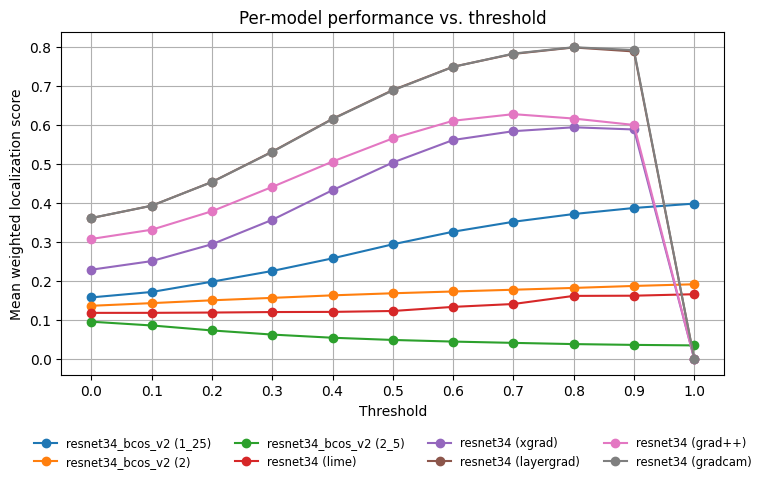

In [16]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

# ─────────── CONFIG ───────────
models = [
    "resnet34_bcos_v2_test_bcos_res_1_25_config",
    #"resnet34_bcos_v2_test_bcos_res_1_75_config",
    "resnet34_bcos_v2_test_bcos_res_2_config",
    "resnet34_bcos_v2_test_bcos_res_2_5_config",
    "resnet34_test_res_lime_config",
    "resnet34_test_res_xgrad_config",
    "resnet34_test_res_layergrad_config",
    "resnet34_test_res_grad++_config",
    "resnet34_test_res_gradcam_config",
    # ggf. weitere Modelle hier
]
results_base = "/pfs/work9/workspace/scratch/ma_tischuet-team_project_explainable_deepfakes/resultsGPG"
grid_subpath  = "3x3"
fname         = "results_by_threshold.pkl"
# ─────────────────────────────────────────

def parse_folder_name(folder: str):
    """
    Aus 'resnet34_test_res_gradcam_config' → ('resnet34', 'gradcam')
    """
    assert folder.endswith("_config"), f"Erwarte Ordnername auf '_config' endend, got {folder}"
    core = folder[:-len("_config")]               # 'resnet34_bcos_v2_test_bcos_res_2_5'
    model, rest = core.split("_test_", 1)          # ['resnet34_bcos_v2', 'bcos_res_2_5']
    xai = rest.split("res_")[1:]
    return model, xai


plt.figure(figsize=(8,5))

for model_name in models:
    model, xai = parse_folder_name(model_name)
    label = f"{model} ({xai[0]})"
    pkl_path = os.path.join(results_base, model_name, grid_subpath, fname)
    if not os.path.isfile(pkl_path):
        print(f"⚠️ missing {pkl_path}")
        continue

    # load grouped-by-threshold dict: { threshold: [entry, ...], ... }
    with open(pkl_path,'rb') as f:
        by_thr = pickle.load(f)

    # sort thresholds numerically
    threshs = sorted(by_thr.keys())
    mean_weighted = []
    #mean_unweighted = []

    for t in threshs:
        entries = by_thr[t]
        if not entries:
            mean_weighted.append(np.nan)
            #mean_unweighted.append(np.nan)
            continue

        w = [e["weighted_localization_score"]   for e in entries]
        #u = [e["unweighted_localization_score"] for e in entries]
        mean_weighted.append(np.mean(w))
        #mean_unweighted.append(np.mean(u))

    plt.plot(threshs, mean_weighted, marker='o', label=label)
    #plt.plot(threshs, mean_unweighted, linestyle='--', marker='x', label=model_name+" (unw.)")

plt.xticks(threshs)                       # Ticks bei 0.0,0.1,...,1.0
plt.xlabel("Threshold")
plt.ylabel("Mean weighted localization score")
plt.title("Per-model performance vs. threshold")
#plt.legend(loc="best", fontsize="small")
plt.legend(
    loc="upper center",              # Position relativ zum bbox_to_anchor
    bbox_to_anchor=(0.5, -0.15),     # (x, y) – x=0.5 Mitte, y<0 unterhalb der Achse
    ncol=4,                          # Anzahl Spalten in der Legende (anpassen!)
    fontsize="small",
    frameon=False
)
plt.grid(True)
plt.tight_layout()
plt.show()

Heatmap comparison 1 image

Saved visualization to results/threshhold_per_unweightedLScore_adab4a77.png


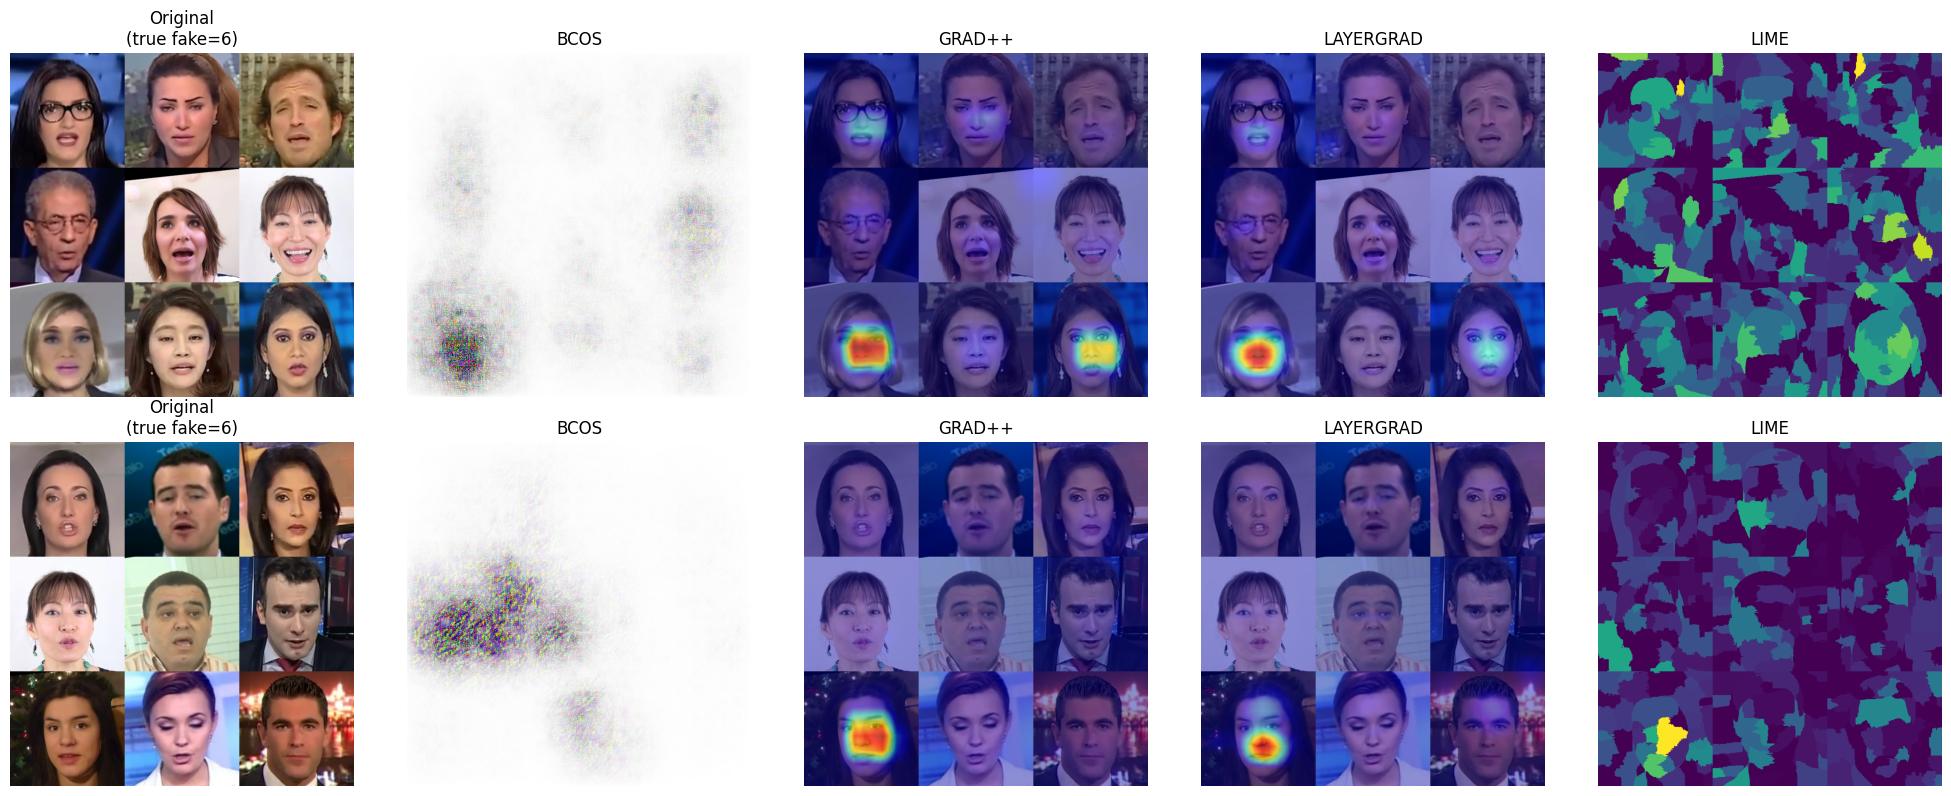

In [19]:
import os
import pickle
import matplotlib.pyplot as plt

# Ordner mit allen .pkl-Dateien
result_dir = "/pfs/work9/workspace/scratch/ma_tischuet-team_project_explainable_deepfakes/resultsGPG/comparemodexeption2"

pkl_files  = [f for f in os.listdir(result_dir) if f.endswith(".pkl")]

# build a map: grid_path → { xai_method: entry, … }
grid_results = {}
for fname in pkl_files:
    xai = fname.split("_")[-1].replace(".pkl","")
    with open(os.path.join(result_dir, fname),"rb") as f:
        by_thr = pickle.load(f)
    for entry in by_thr.get(0.0,[]):
        p = entry["path"]
        grid_results.setdefault(p, {})[xai] = entry

# pick first N grids
N = 3
shared = list(grid_results.keys())[:N]
methods = sorted(next(iter(grid_results.values())).keys())

fig, axes = plt.subplots(
    nrows=len(shared),
    ncols=len(methods)+1,
    figsize=(4*(len(methods)+1),4*len(shared))
)

for i, p in enumerate(shared):
    row = grid_results[p]
    # get the “true fake” index
    true_pos = row[next(iter(row))]["true_fake_position"]

    # original
    orig = row.get("bcos", next(iter(row.values())))["original_image"]
    ax = axes[i,0]
    ax.imshow(orig)
    ax.set_title(f"Original\n(true fake={true_pos})")
    ax.axis("off")

    # each heatmap
    for j, m in enumerate(methods, start=1):
        hm = row[m]["heatmap"]
        ax = axes[i,j]
        ax.imshow(hm)
        ax.set_title(m.upper())
        ax.axis("off")

save_folder="results"
# Sicherstellen, dass der Speicherordner existiert.
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

# Eindeutigen Dateinamen generieren: Prefix, echte/erratene Position und ein zufälliger UUID-Teil.
unique_id = uuid.uuid4().hex[:8]
filename = f"threshhold_per_unweightedLScore_{unique_id}.png"
filepath = os.path.join(save_folder, filename)

# Abbildung speichern.
plt.savefig(filepath)
print(f"Saved visualization to {filepath}")

plt.tight_layout()
plt.show()

COMPARE

Saved visualization to results/boxplot_resnet_gpg_90bb28eb.png


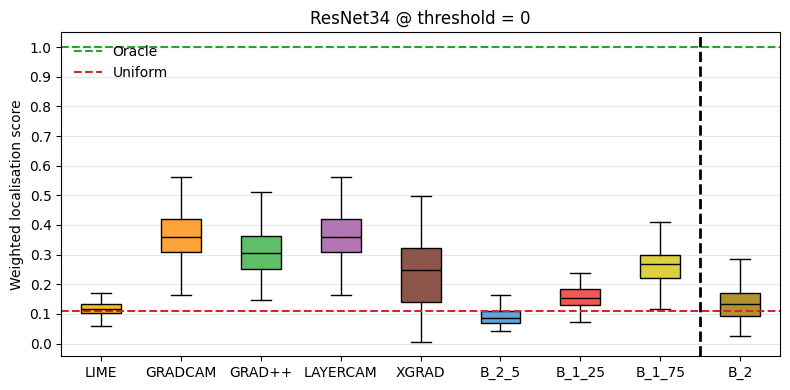

In [18]:
import os, pickle, uuid
import numpy as np
import matplotlib.pyplot as plt

# ─── CONFIG ────────────────────────────────────────────────────────────────
BASE_DIR = "/pfs/work9/workspace/scratch/ma_tischuet-team_project_explainable_deepfakes/resultsGPG"

FOLDER_MAP = {
    "lime":      "resnet34_test_res_lime_config",
    "gradcam":   "resnet34_test_res_gradcam_config",
    "grad++":    "resnet34_test_res_grad++_config",
    "layercam":  "resnet34_test_res_layergrad_config",
    "xgrad":     "resnet34_test_res_xgrad_config",
    "b_2_5":     "resnet34_bcos_v2_test_bcos_res_2_5_config",
    "b_1_25":    "resnet34_bcos_v2_test_bcos_res_1_25_config",
    "b_1_75":    "resnet34_bcos_v2_test_bcos_res_1_75_config",
    "b_2":       "resnet34_bcos_v2_test_bcos_res_2_config",
}

ORDER_SHORT = ["lime", "gradcam", "grad++", "layercam", "xgrad", "b_2_5", "b_1_25", "b_1_75", "b_2"]

COLORS = {
    "lime":     "#F9BC1B",
    "gradcam":  "#FAA43A",
    "grad++":   "#60BD68",
    "layercam": "#B276B2",
    "xgrad":    "#8C564B",
    "b_2_5":    "#5DA5DA",
    "b_1_25":   "#F15854",
    "b_1_75":   "#DECF3F",
    "b_2":      "#B2912F",
}

RESULT_FILENAME = "3x3/results_by_threshold.pkl"
# ──────────────────────────────────────────────────────────────────────────

plt.figure(figsize=(8, 4))
box_data = []
labels = []

for short in ORDER_SHORT:
    folder = FOLDER_MAP.get(short)
    if folder is None:
        print(f"No folder mapping for {short}")
        continue

    path = os.path.join(BASE_DIR, folder, RESULT_FILENAME)
    if not os.path.exists(path):
        print(f"Missing file: {path}")
        continue

    with open(path, "rb") as f:
        by_thr = pickle.load(f)

    entries = by_thr.get(0, [])  # threshold = 0
    scores_w = [e["weighted_localization_score"] for e in entries]
    box_data.append(scores_w)
    labels.append(short)  # KEEP original case for correct color matching

bp = plt.boxplot(
    box_data,
    tick_labels=[lbl.upper() for lbl in labels],
    patch_artist=True,
    showfliers=False,
    medianprops={"color": "black"}
)

for box, lbl in zip(bp["boxes"], labels):
    box.set_facecolor(COLORS.get(lbl, "lightgray"))

plt.xlim(0.5, len(box_data) + 0.5)
divider_x = len(box_data) - 0.5
plt.axvline(divider_x, color="black", linestyle="--", linewidth=2, zorder=5)

plt.axhline(1.0, ls="--", color="#2ca02c", label="Oracle")    # Optional: explicit green
plt.axhline(1/9, ls="--", color="#d62728", label="Uniform")   # Optional: explicit red
plt.title("ResNet34 @ threshold = 0")
plt.ylabel("Weighted localisation score")
plt.yticks(np.arange(0.0, 1.01, 0.1))
plt.grid(axis="y", alpha=0.3)
plt.legend(loc="upper left", frameon=False)
plt.tight_layout()

save_folder = "results"
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

unique_id = uuid.uuid4().hex[:8]
filename = f"boxplot_resnet_gpg_{unique_id}.png"
filepath = os.path.join(save_folder, filename)

plt.savefig(filepath)
print(f"Saved visualization to {filepath}")
plt.show()

own data 

✅ compare-mode loading: results_by_threshold_resnet34_lime.pkl
✅ compare-mode loading: results_by_threshold_resnet34_gradcam.pkl
✅ compare-mode loading: results_by_threshold_resnet34_grad++.pkl
✅ compare-mode loading: results_by_threshold_resnet34_layergrad.pkl
✅ compare-mode loading: results_by_threshold_resnet34_xgrad.pkl
✅ compare-mode loading: results_by_threshold_resnet34_bcos_v2_bcos.pkl
✅ compare-mode loading: results_by_threshold_resnet34_lime.pkl
✅ compare-mode loading: results_by_threshold_resnet34_gradcam.pkl
✅ compare-mode loading: results_by_threshold_resnet34_grad++.pkl
✅ compare-mode loading: results_by_threshold_resnet34_layergrad.pkl
✅ compare-mode loading: results_by_threshold_resnet34_xgrad.pkl
✅ compare-mode loading: results_by_threshold_resnet34_bcos_v2_bcos.pkl


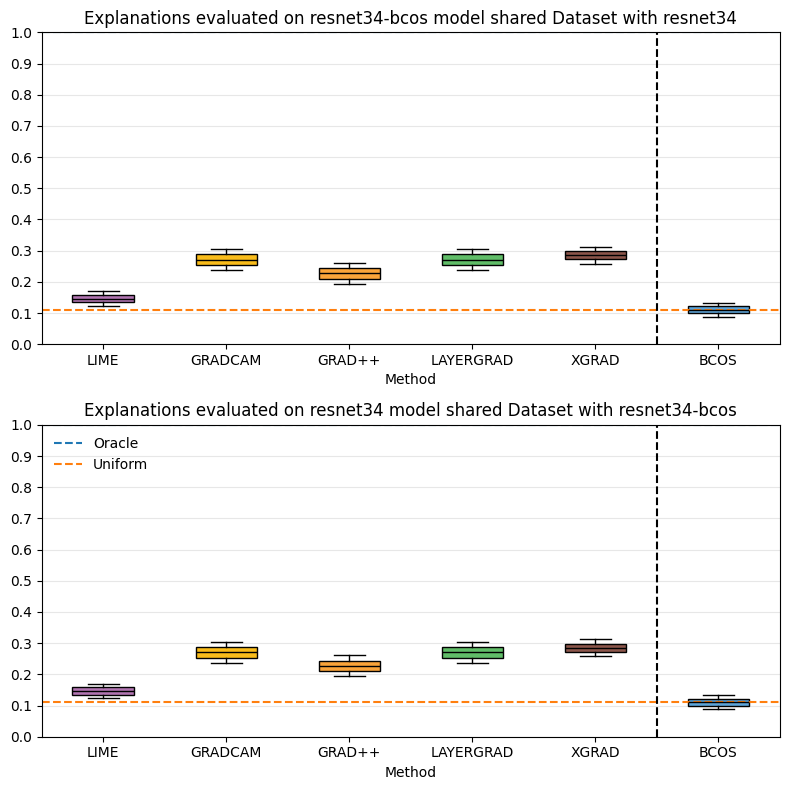

In [63]:
import os
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt

# ─── YOUR SETTINGS ──────────────────────────────────────────────────────────
METHODS       = ["lime","gradcam","grad++","layergrad","xgrad","bcos"]
COLORS = {
    "LIME":      "#B276B2",
    "GRADCAM":   "#F9BC1B",
    "GRAD++":    "#FAA43A",
    "LAYERGRAD": "#60BD68",
    "XGRAD":     "#8C564B",
    "BCOS":      "#5DA5DA",
}

# compare-mode: look under this folder for
#    results_by_threshold_resnet34_<method>.pkl

COMPARE_DIR = "/pfs/work9/workspace/scratch/ma_tischuet-team_project_explainable_deepfakes/resultsGPG/comparemode"
COMPARE_PFX = "results_by_threshold_resnet34_"
COMPARE_SFX = ".pkl"

# ─── YOUR SETTINGS ──────────────────────────────────────────────────────────


# compare-mode: look under this folder for
#    results_by_threshold_resnet34_<method>.pkl

Bcos_DIR = "/pfs/work9/workspace/scratch/ma_tischuet-team_project_explainable_deepfakes/resultsGPG/comparemode"
Bcos_PFX = "results_by_threshold_resnet34_"
Bcos_SFX = ".pkl"

# ──────────────────────────────────────────────────────────────────────────


def load_box_data_compare():
    box, labels = [], []
    for m in METHODS:
        # try exact then wildcard
        exact = os.path.join(COMPARE_DIR, COMPARE_PFX + m + COMPARE_SFX)
        if os.path.isfile(exact):
            path = exact
        else:
            pat = os.path.join(COMPARE_DIR, COMPARE_PFX + "*" + "_" + m + COMPARE_SFX)
            matches = glob.glob(pat)
            path = matches[0] if matches else None

        if not path:
            print(f"⚠️  compare-mode missing “{m}”")
            box.append([])
            labels.append(m.upper())
            continue

        print(f"✅ compare-mode loading: {os.path.basename(path)}")
        with open(path, "rb") as f:
            by_thr = pickle.load(f)
        entries = by_thr.get(0, [])
        scores  = [e["weighted_localization_score"] for e in entries]
        box.append(scores)
        labels.append(m.upper())
    return box, labels


def load_box_data_own():
    box, labels = [], []
    for m in METHODS:
        # try exact then wildcard
        exact = os.path.join(Bcos_DIR, Bcos_PFX + m + Bcos_SFX)
        if os.path.isfile(exact):
            path = exact
        else:
            pat = os.path.join(Bcos_DIR, Bcos_PFX + "*" + "_" + m + Bcos_SFX)
            matches = glob.glob(pat)
            path = matches[0] if matches else None

        if not path:
            print(f"⚠️  compare-mode missing “{m}”")
            box.append([])
            labels.append(m.upper())
            continue

        print(f"✅ compare-mode loading: {os.path.basename(path)}")
        with open(path, "rb") as f:
            by_thr = pickle.load(f)
        entries = by_thr.get(0, [])
        scores  = [e["weighted_localization_score"] for e in entries]
        box.append(scores)
        labels.append(m.upper())
    return box, labels



# ─── build and plot ────────────────────────────────────────────────────────
box_top,    labels_top    = load_box_data_compare()
box_bottom, labels_bottom = load_box_data_own()

divider = len(METHODS) - 0.5

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=False)

for ax, boxd, labs, title in [
    (ax1, box_top,    labels_top,    "Explanations evaluated on resnet34-bcos model shared Dataset with resnet34"),
    (ax2, box_bottom, labels_bottom, "Explanations evaluated on resnet34 model shared Dataset with resnet34-bcos"),]:
    bp = ax.boxplot(
        boxd,
        patch_artist=True,
        showfliers=False,
        medianprops={"color":"black"},)
    for box, lbl in zip(bp["boxes"], labs):
        box.set_facecolor(COLORS.get(lbl, "lightgray"))

    # vertical divider before BCoS
    ax.axvline(divider, color="black", linestyle="--", linewidth=1.5, zorder=5)
    # horizontal baselines
    ax.axhline(1.0, ls="--", color="C0", label="Oracle")
    ax.axhline(1/9, ls="--", color="C1", label="Uniform")

    ax.set_title(title)
    ax.set_ylim(0, 1)
    ax.set_yticks(np.arange(0, 1.01, 0.1))
    ax.grid(axis="y", alpha=0.3)

# label top plot
ax1.set_xticks(np.arange(1, len(labels_top) + 1))
ax1.set_xticklabels(labels_top, rotation=0)
ax1.set_xlabel("Method")

# bottom: label x-ticks and add legend
ax2.set_xticks(np.arange(1, len(METHODS)+1))
ax2.set_xticklabels(labels_bottom, rotation=0)
ax2.set_xlabel("Method")
ax2.legend(loc="upper left", frameon=False)

plt.tight_layout()
plt.show()